# Vendor Performance Analytics
## Loading Data from PostgreSQL and Performing Analysis

This notebook loads the `vendor_sales_summary` table from PostgreSQL and performs comprehensive vendor performance analysis.

In [14]:
# importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
import urllib.parse
from scipy.stats import ttest_ind
import scipy.stats as stats
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [5]:
# connecting database 
# PostgreSQL connection parameters
DB_HOST = "localhost"
DB_PORT = 5433
DB_NAME = "inventory_db"
DB_USER = "postgres"
DB_PASSWORD = urllib.parse.quote_plus("NISHU@123")   # auto-fix special characters
# Create connection string for SQLAlchemy
connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

print("✅ PostgreSQL Connected Successfully!")

✅ PostgreSQL Connected Successfully!


In [6]:
# loading vendor_sales_summary_table 
query = "SELECT * FROM vendor_sales_summary"

df = pd.read_sql(query, engine)

print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Data loaded successfully!
Shape: (10692, 18)

First few rows:


,vendor_number,vendor_name,brand,description,purchase_price,actual_price,volume,total_purchase_quantity,total_purchase_dollars,total_sales_quantity,total_sales_dollars,total_sales_price,total_excise_tax,freight_cost,gross_profit,profit_margin,stock_turnover,sales_to_purchase_ratio
0,480,BACARDI USA INC,3348,Bombay Sapphire Gin,22.38,29.99,1750,57349,1283470.62,56888,1766391.12,460087.95,104524.54,89286.27,482920.50,27.34,0.99,1.38
1,480,BACARDI USA INC,3857,Grey Goose Vodka,38.27,49.99,1750,33388,1277758.76,32945,1699669.55,589137.79,60533.43,89286.27,421910.79,24.82,0.99,1.33
2,9552,M S WALKER INC,24820,Ch Bourbon La Chapelle Medoc,10.13,14.99,750,1,10.13,0,0.00,0.00,0.00,55551.82,-10.13,0.00,0.00,0.00
3,11567,CAMPARI AMERICA,8085,Wild Turkey,25.59,35.99,1750,5823,149010.57,4555,150722.45,110263.73,8373.74,20964.81,1711.88,1.14,0.78,1.01
4,8664,"STOLI GROUP,(USA) LLC",8112,Stolichnaya,19.52,24.99,1750,61936,1208990.72,61323,1528730.27,392353.54,112669.45,18544.49,319739.55,20.92,0.99,1.26


## Exploratory Data Analysis 
- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [8]:
# Basic information about the dataset

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total Records: {len(df):,}")
print(f"Total Vendors: {df['vendor_number'].nunique():,}")
print(f"Total Brands: {df['brand'].nunique():,}")
print("\n" + "=" * 60)


DATASET OVERVIEW
Total Records: 10,692
Total Vendors: 126
Total Brands: 10,663



In [9]:
# Data types and missing values

print("DATA TYPES AND MISSING VALUES")
print("=" * 60)
info_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(info_df.to_string(index=False))

DATA TYPES AND MISSING VALUES
                 Column Data Type  Non-Null Count  Null Count  Null Percentage
          vendor_number     int64           10692           0              0.0
            vendor_name    object           10692           0              0.0
                  brand     int64           10692           0              0.0
            description    object           10692           0              0.0
         purchase_price   float64           10692           0              0.0
           actual_price   float64           10692           0              0.0
                 volume    object           10692           0              0.0
total_purchase_quantity     int64           10692           0              0.0
 total_purchase_dollars   float64           10692           0              0.0
   total_sales_quantity     int64           10692           0              0.0
    total_sales_dollars   float64           10692           0              0.0
      total_sales_pric

In [20]:
df['volume'] = df['volume'].astype(float) # changing data type of volume column

In [21]:
# Summary statistics for numeric columns

summary_stats = df.describe().T
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
vendor_number,10692.0,10650.649458,18753.519148,2.00,3951.0000,7153.000,9552.0000,201359.00
brand,10692.0,18039.228769,12662.187074,58.00,5793.5000,18761.500,25514.2500,90631.00
purchase_price,10692.0,24.385303,109.269375,0.36,6.8400,10.455,19.4825,5681.81
actual_price,10692.0,35.643671,148.246016,0.49,10.9900,15.990,28.9900,7499.99
volume,10692.0,847.360550,664.309212,50.00,750.0000,750.000,750.0000,20000.00
total_purchase_quantity,10692.0,3140.886831,11095.086769,1.00,36.0000,262.000,1975.7500,337660.00
total_purchase_dollars,10692.0,30106.693372,123067.799627,0.71,453.4575,3655.465,20738.2450,3811251.60
total_sales_quantity,10692.0,3077.482136,10952.851391,0.00,33.0000,261.000,1929.2500,334939.00
total_sales_dollars,10692.0,42239.074419,167655.265984,0.00,729.2200,5298.045,28396.9150,5101919.51
total_sales_price,10692.0,18793.783627,44952.773386,0.00,289.7100,2857.800,16059.5625,672819.31


In [22]:
# Mode for each numerical column

mode_values = df.mode().iloc[0]
print("\nMode Values:\n\n", mode_values)


Mode Values:

 vendor_number                             4425.0
vendor_name                MARTIGNETTI COMPANIES
brand                                        809
description                     Southern Comfort
purchase_price                              6.53
actual_price                                9.99
volume                                     750.0
total_purchase_quantity                     12.0
total_purchase_dollars                     95.28
total_sales_quantity                        12.0
total_sales_dollars                          0.0
total_sales_price                            0.0
total_excise_tax                             0.0
freight_cost                           144929.24
gross_profit                              -106.8
profit_margin                                0.0
stock_turnover                               1.0
sales_to_purchase_ratio                     1.48
Name: 0, dtype: object


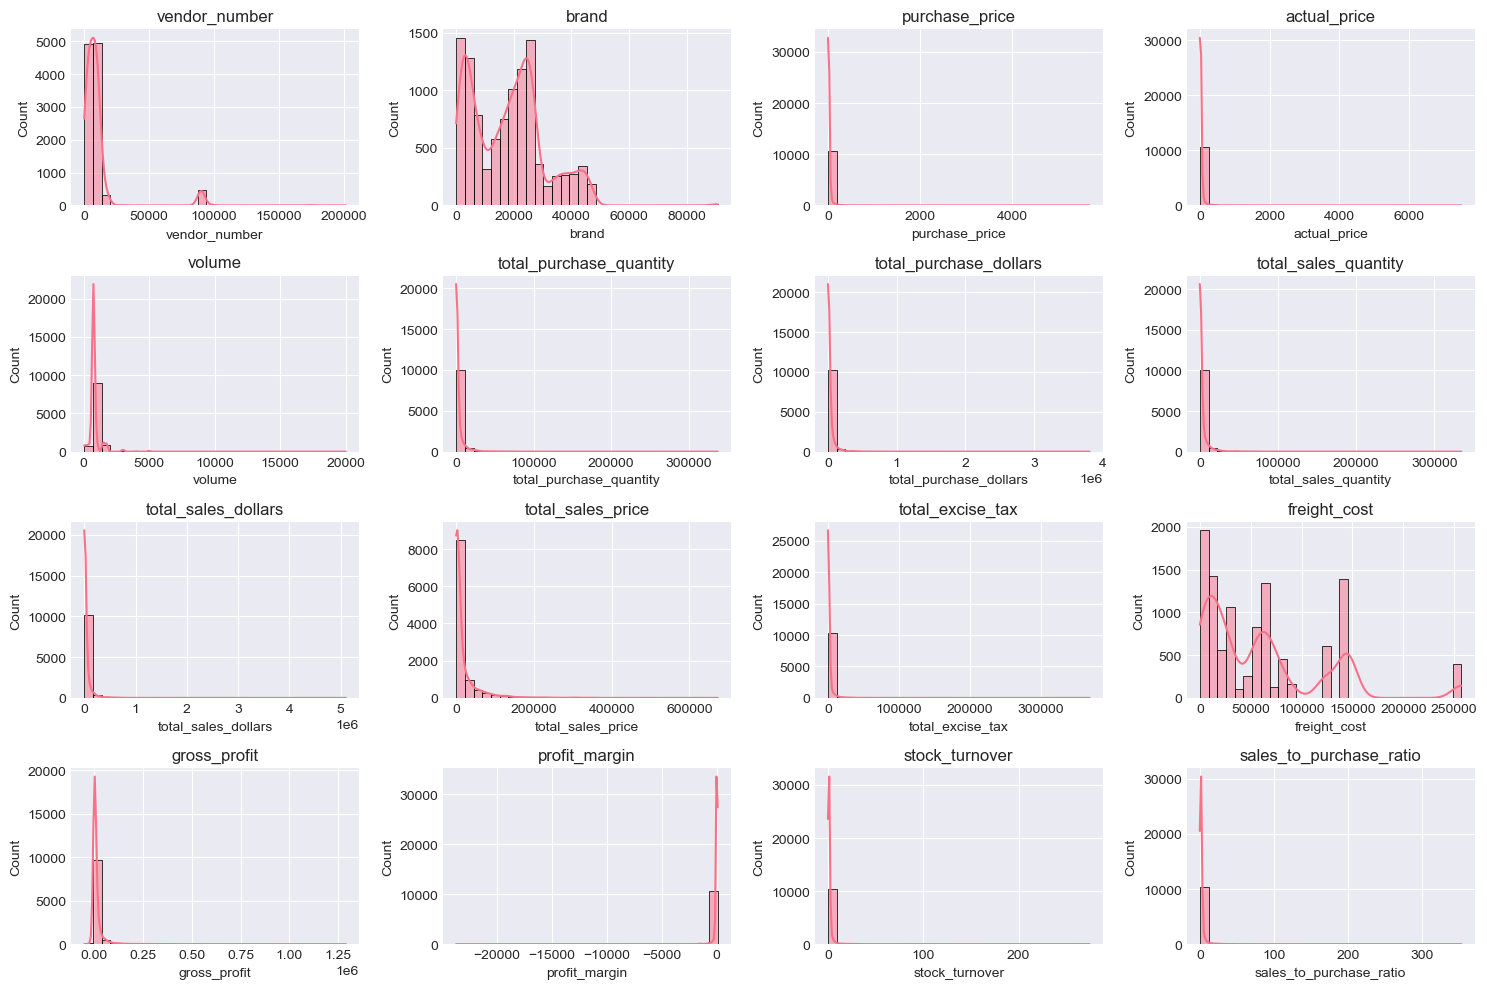

In [23]:
# Distribution Plots for Numerical Columns
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)  # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

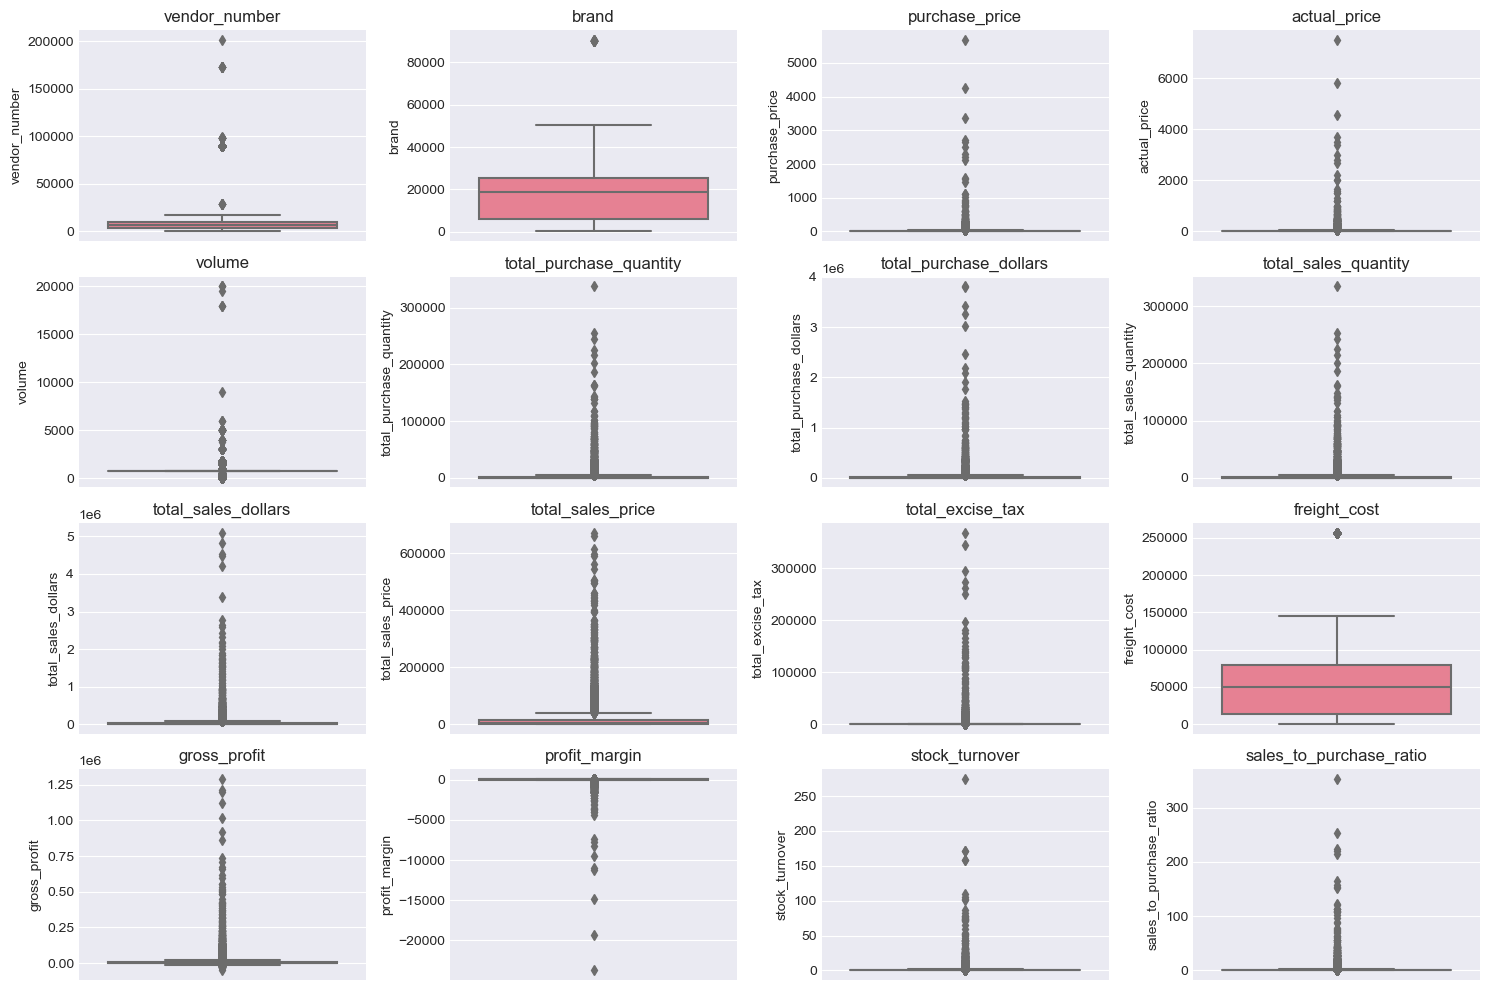

In [24]:
# Outlier Detection with Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## Summary Statistics Insights:
**Negative & Zero Values:**

- Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
- Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.
- Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

**Outliers Indicated by High Standard Deviations:**

- Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
- Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
- Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [25]:
# Filter data to remove inconsistencies
# Keep only records with positive gross profit, positive profit margin, and positive sales quantity
print("FILTERING DATA - REMOVING INCONSISTENCIES")
print("=" * 60)
print(f"Original record count: {len(df):,}")

# Filter conditions
df_filtered = df[
    (df['gross_profit'] > 0) &
    (df['profit_margin'] > 0) &
    (df['total_sales_quantity'] > 0)
].copy()

print(f"Filtered record count: {len(df_filtered):,}")
print(f"Records removed: {len(df) - len(df_filtered):,}")
print(f"Percentage kept: {(len(df_filtered) / len(df) * 100):.2f}%")
print("=" * 60)

# Use filtered dataframe for all subsequent analysis
df = df_filtered

print("\nData filtering complete! Using cleaned dataset for analysis.")

FILTERING DATA - REMOVING INCONSISTENCIES
Original record count: 10,692
Filtered record count: 8,564
Records removed: 2,128
Percentage kept: 80.10%

Data filtering complete! Using cleaned dataset for analysis.


In [26]:
# Saving data back to postgresql  
df.to_sql(
    name="vendor_sales_summary_cleaned",
    con=engine,
    if_exists="replace",   # recreate clean table
    index=False,
    chunksize=1000
)

print("Cleaned analytics table created successfully!")


Cleaned analytics table created successfully!


In [27]:
df.shape

(8564, 18)

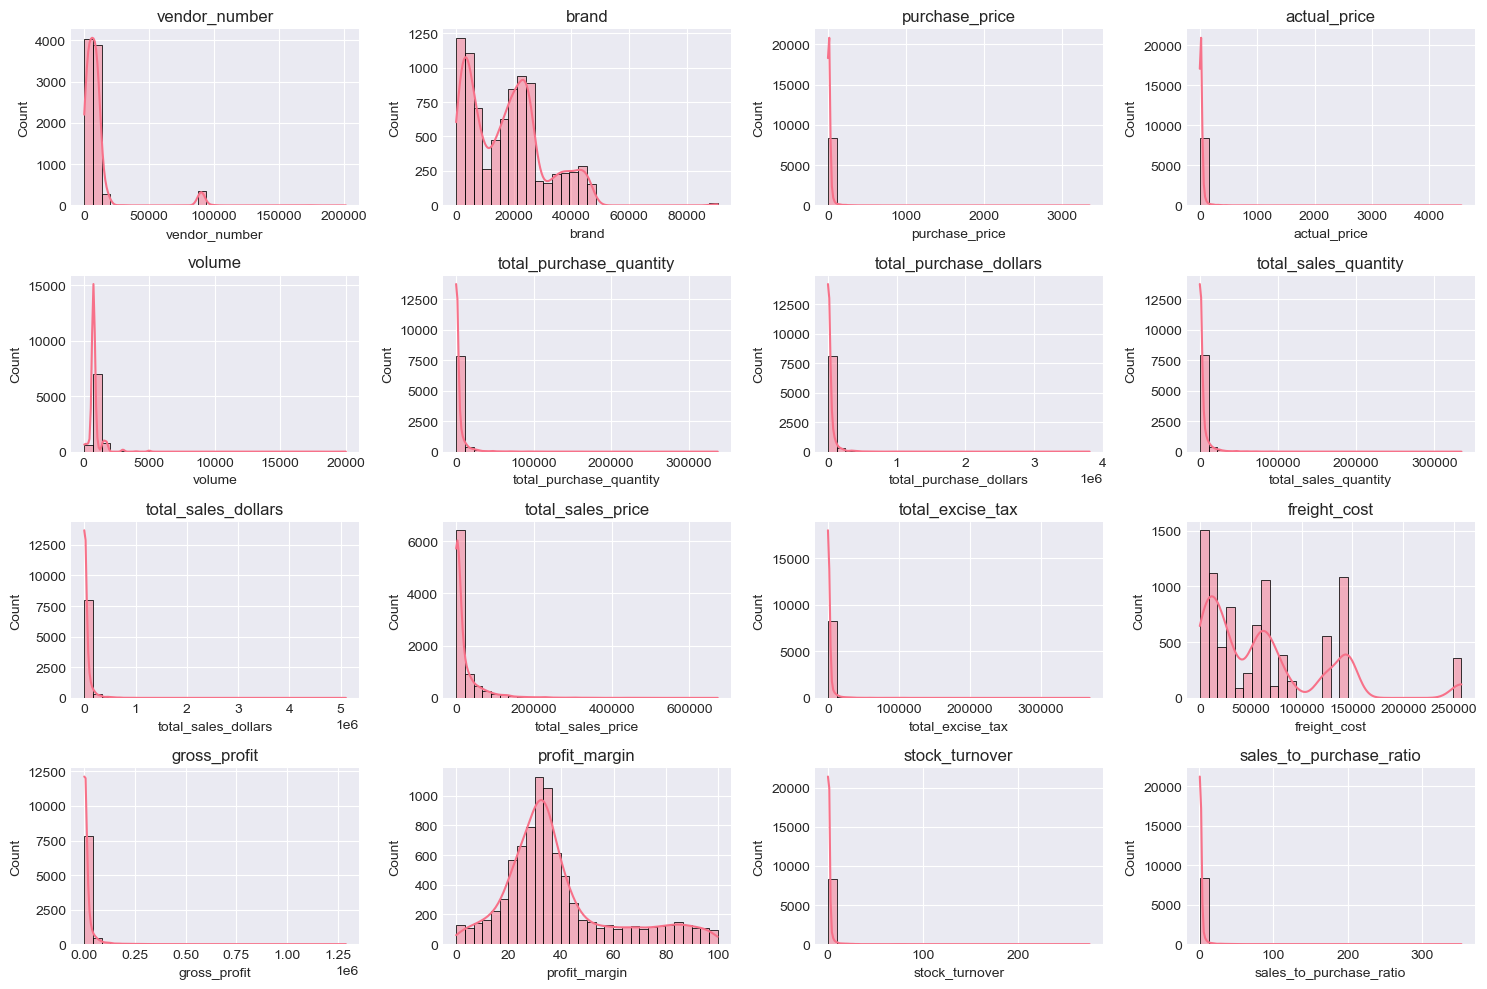

In [28]:
# Distribution Plots for Numerical Columns
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)  # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

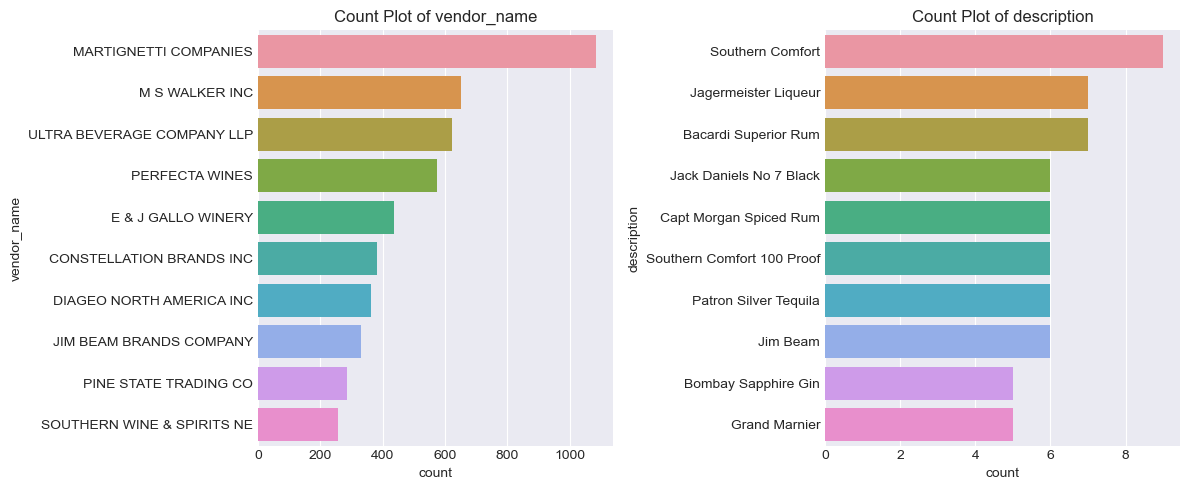

In [32]:
# Count Plots for Categorical Columns
categorical_cols = ["vendor_name", "description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])  # Top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

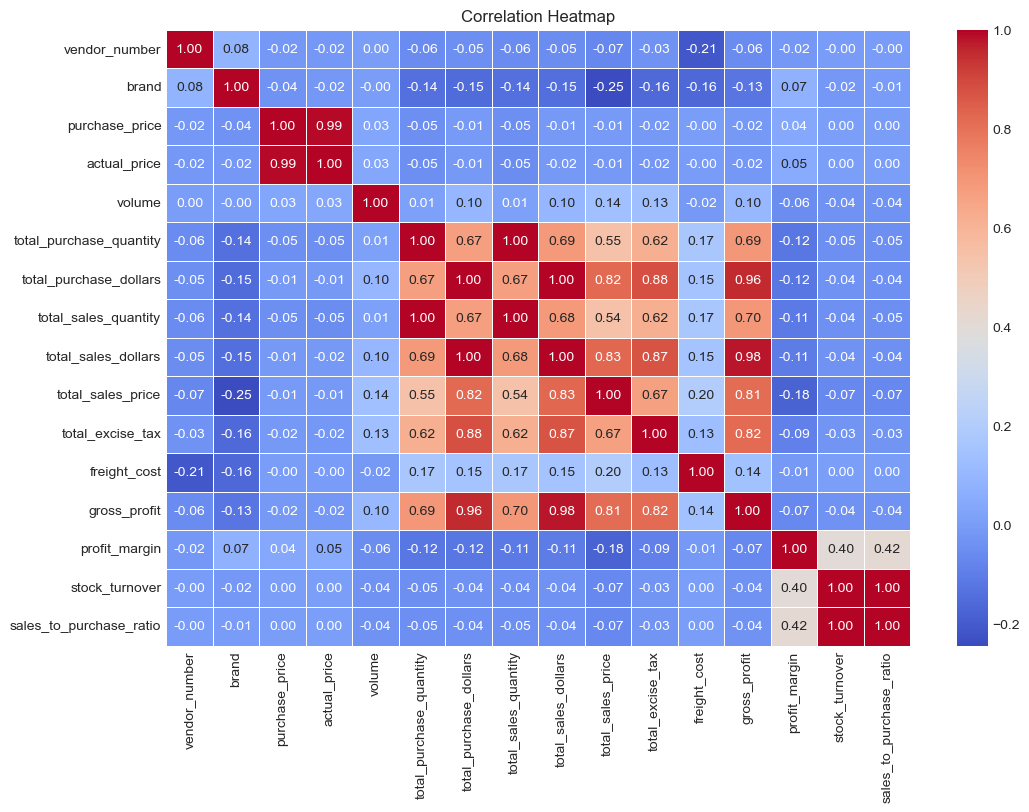

In [33]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Correlation Insights
- PurchasePrice has weak correlations with TotalSalesDollars (-0.012) and GrossProfit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
- Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
- Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
- StockTurnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.


## Data Analysis - Business Problems

### Identify Brands that needs Promotional or Pricing Adjustments which exhibit lower sales performance but higher profit margins.

In [36]:
brand_performance = df.groupby('description').agg({
    'total_sales_dollars': 'sum',  # Sales performance metric
    'profit_margin': 'mean'       # Average profit margin
}).reset_index()

brand_performance.sort_values('profit_margin')

,description,total_sales_dollars,profit_margin
5485,Pepperjack Barossa Red,191.92,0.02
2954,Flint & Steel Svgn Bl Napa V,119.92,0.03
2179,Croft Tawny Porto,191.84,0.04
2561,Douglass Hill Merlot,143.76,0.08
5385,Parducci 13 True Grit Chard,24927.81,0.12
...,...,...,...
4568,M Chiarlo Gavi Wh,1208.90,99.39
657,Beniotome Sesame Shochu,4768.41,99.53
6449,Skinnygirl Tangerine Vodka,2368.42,99.54
2411,DiSaronno Amaretto,4781.16,99.55


In [37]:
# threshold for "low sales" (bottom 15%) and "high margin" (top 15%)
low_sales_threshold = brand_performance['total_sales_dollars'].quantile(0.15) 
high_margin_threshold = brand_performance['profit_margin'].quantile(0.85) # this is in %

# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['total_sales_dollars'] <= low_sales_threshold) &
    (brand_performance['profit_margin'] >= high_margin_threshold)
]
print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('total_sales_dollars'))

Brands with Low Sales but High Profit Margins:


,description,total_sales_dollars,profit_margin
6199,Santa Rita Organic Svgn Bl,9.99,66.47
2369,Debauchery Pnt Nr,11.58,65.98
2070,Concannon Glen Ellen Wh Zin,15.95,83.45
2188,Crown Royal Apple,27.86,89.81
6237,Sauza Sprklg Wild Berry Marg,27.96,82.15
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.75
2271,Dad's Hat Rye Whiskey,538.89,81.85
57,A Bichot Clos Marechaudes,539.94,67.74
6245,Sbragia Home Ranch Merlot,549.75,66.44


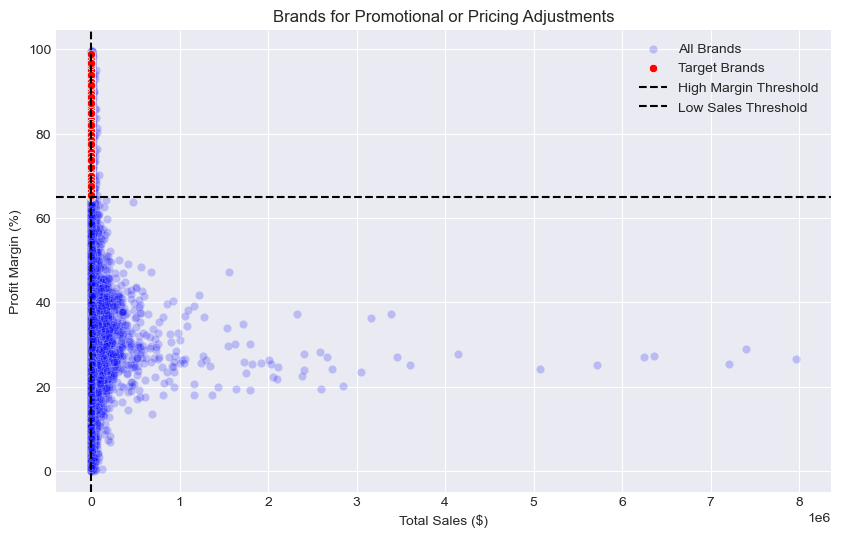

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='total_sales_dollars', y='profit_margin', color="blue", label="All Brands", alpha = 0.2)
sns.scatterplot(data=target_brands, x='total_sales_dollars', y='profit_margin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
brand_performance = brand_performance[brand_performance['total_sales_dollars']<10000] # for better visualization

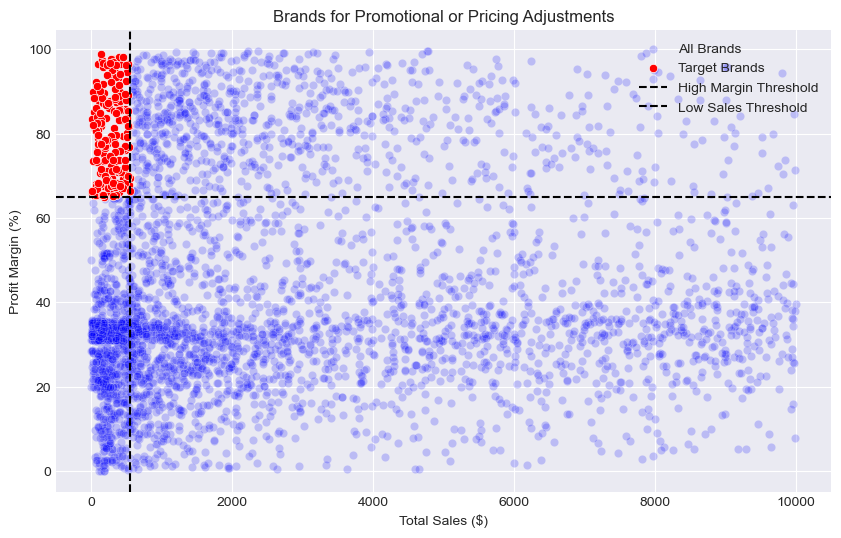

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='total_sales_dollars', y='profit_margin', color="blue", label="All Brands", alpha = 0.2)
sns.scatterplot(data=target_brands, x='total_sales_dollars', y='profit_margin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

### Which vendors and brands demonstrate the highest sales performance?

In [44]:
# Top Vendors & Brands by Sales Performance
top_vendors = df.groupby("vendor_name")["total_sales_dollars"].sum().nlargest(10)
top_brands = df.groupby("description")["total_sales_dollars"].sum().nlargest(10)
top_vendors

vendor_name
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: total_sales_dollars, dtype: float64

In [45]:
top_brands

description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: total_sales_dollars, dtype: float64

In [46]:
# Function for reading values
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)
    


In [47]:
top_vendors.apply(lambda x:format_dollars(x))

vendor_name
DIAGEO NORTH AMERICA INC      67.99M
MARTIGNETTI COMPANIES         39.33M
PERNOD RICARD USA             32.06M
JIM BEAM BRANDS COMPANY       31.42M
BACARDI USA INC               24.85M
CONSTELLATION BRANDS INC      24.22M
E & J GALLO WINERY            18.40M
BROWN-FORMAN CORP             18.25M
ULTRA BEVERAGE COMPANY LLP    16.50M
M S WALKER INC                14.71M
Name: total_sales_dollars, dtype: object

In [48]:
top_brands.apply(lambda x:format_dollars(x))

description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: total_sales_dollars, dtype: object

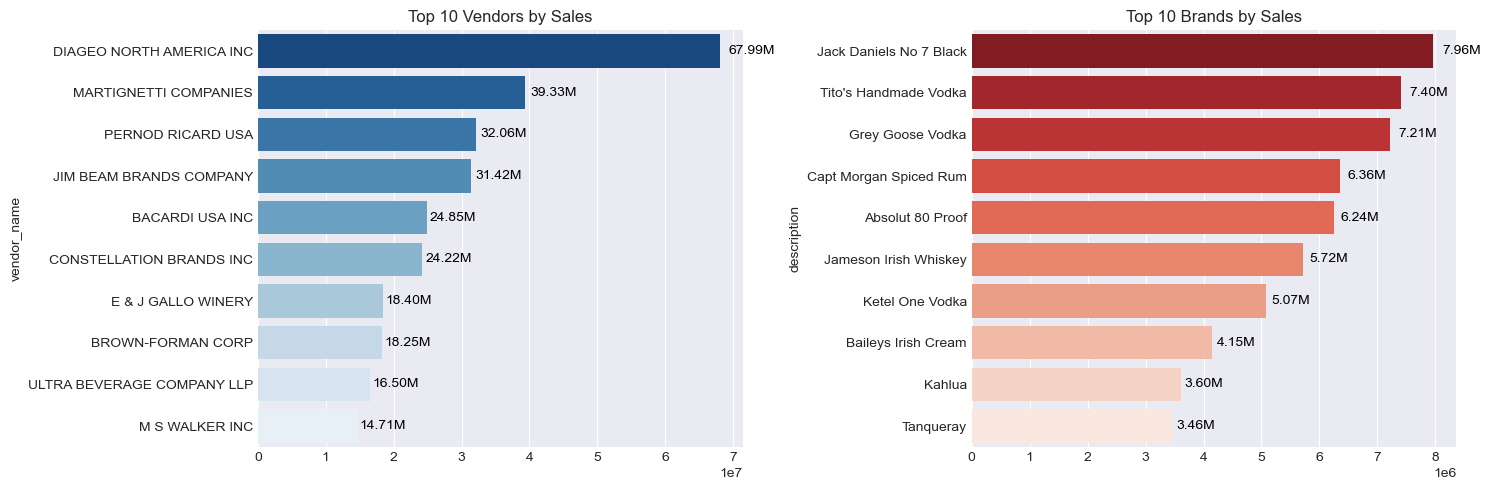

In [49]:
# Now visualization 
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02), 
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), 
             ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02), 
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), 
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Which vendors contribute the most to total purchase dollars?

In [53]:
# Rank Vendors by Total Purchase Dollars
vendor_performance = df.groupby("vendor_name").agg({
    "total_purchase_dollars": "sum",
    "gross_profit": "sum",
    "total_sales_dollars": "sum"
}).reset_index()

# Calculate Contribution % to Overall Procurement
vendor_performance["purchase_contribution_pct"] = (
    vendor_performance["total_purchase_dollars"] /
    vendor_performance["total_purchase_dollars"].sum()
) * 100

# Rank Vendors by Total Purchase Dollars & Profitability
vendor_performance = vendor_performance.sort_values(
    by="total_purchase_dollars",
    ascending=False
).round(2)

# Display Top 10 Vendors
top_vendors = vendor_performance.head(10).copy()

top_vendors["total_sales_dollars"] = top_vendors["total_sales_dollars"].apply(format_dollars)
top_vendors["total_purchase_dollars"] = top_vendors["total_purchase_dollars"].apply(format_dollars)
top_vendors["gross_profit"] = top_vendors["gross_profit"].apply(format_dollars)

top_vendors


,vendor_name,total_purchase_dollars,gross_profit,total_sales_dollars,purchase_contribution_pct
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [52]:
df.columns

Index(['vendor_number', 'vendor_name', 'brand', 'description',
       'purchase_price', 'actual_price', 'volume', 'total_purchase_quantity',
       'total_purchase_dollars', 'total_sales_quantity', 'total_sales_dollars',
       'total_sales_price', 'total_excise_tax', 'freight_cost', 'gross_profit',
       'profit_margin', 'stock_turnover', 'sales_to_purchase_ratio'],
      dtype='object')

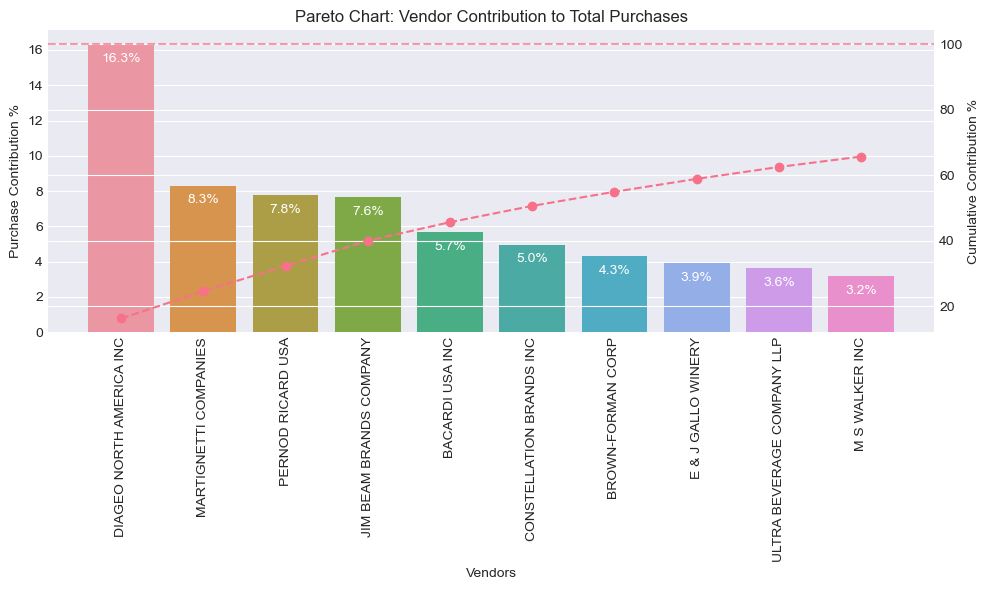

In [54]:
# Cumulative contribution
top_vendors["cumulative_contribution_pct"] = top_vendors["purchase_contribution_pct"].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot – Purchase Contribution %
sns.barplot(
    x=top_vendors["vendor_name"],
    y=top_vendors["purchase_contribution_pct"],
    ax=ax1
)

# Bar labels
for i, value in enumerate(top_vendors["purchase_contribution_pct"]):
    ax1.text(i, value - 1, f"{value:.1f}%", ha="center", fontsize=10, color="white")

# Line plot – Cumulative %
ax2 = ax1.twinx()
ax2.plot(
    top_vendors["vendor_name"],
    top_vendors["cumulative_contribution_pct"],
    marker="o",
    linestyle="dashed"
)

ax1.set_xticklabels(top_vendors["vendor_name"], rotation=90)
ax1.set_ylabel("Purchase Contribution %")
ax2.set_ylabel("Cumulative Contribution %")
ax1.set_xlabel("Vendors")
ax1.set_title("Pareto Chart: Vendor Contribution to Total Purchases")

ax2.axhline(y=100, linestyle="dashed", alpha=0.7)

plt.tight_layout()
plt.show()


### How much of total procurement is dependent on the top vendors?

Total Purchase Contribution of top 10 vendors is 65.69 %


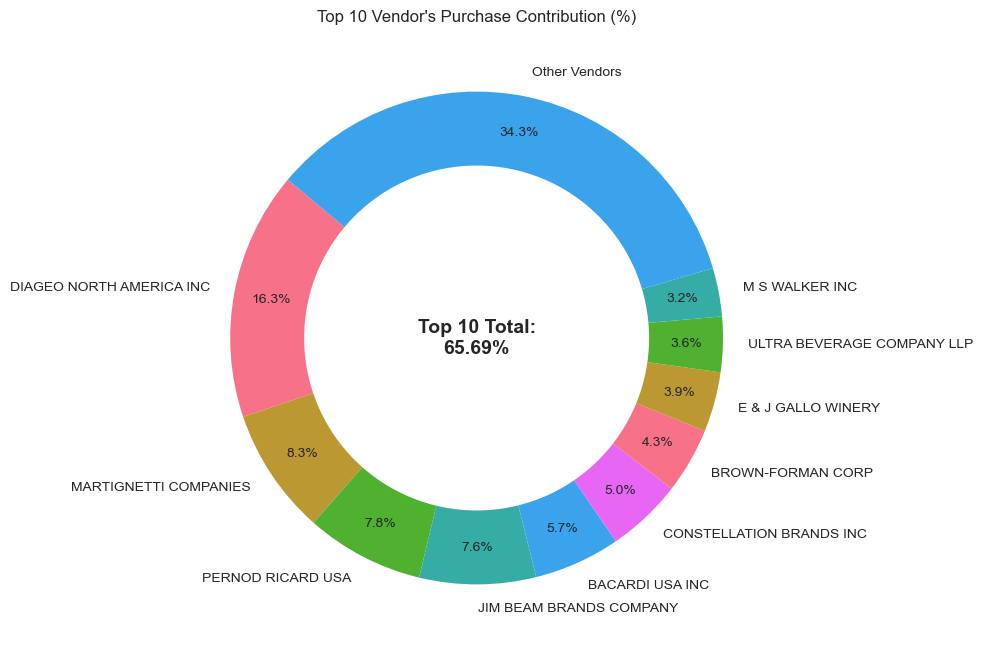

In [55]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['purchase_contribution_pct'].sum(),2)} %")

vendors = list(top_vendors["vendor_name"].values)
purchase_contributions = list(top_vendors["purchase_contribution_pct"].values)

total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors"
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    purchase_contributions,
    labels=vendors,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.85
)

# White center circle (donut)
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Center annotation
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", 
         fontsize=14, fontweight="bold", ha="center", va="center")

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()


### The top 10 vendors account for 65.69% of the total purchase value, while all other vendors together contribute only 34.31%.
### This shows that the company depends heavily on a few vendors. To reduce risk, new suppliers can be added so that purchases are not concentrated on only a few vendors.

### Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [56]:
# Calculate Unit Purchase Price per Vendor & Volume Group
df["UnitPurchasePrice"] = df["total_purchase_dollars"] / df["total_purchase_quantity"]

# Group by Order Sizes (e.g., Small, Medium, Large Purchases)
df["OrderSize"] = pd.qcut(df["total_purchase_quantity"], q=3, labels=["Small", "Medium", "Large"])

# Analyze Cost Savings per Order Size
bulk_purchase_analysis = df.groupby("OrderSize")["UnitPurchasePrice"].mean().reset_index()
print(bulk_purchase_analysis)


  OrderSize  UnitPurchasePrice
0     Small          39.068186
1    Medium          15.486414
2     Large          10.777625


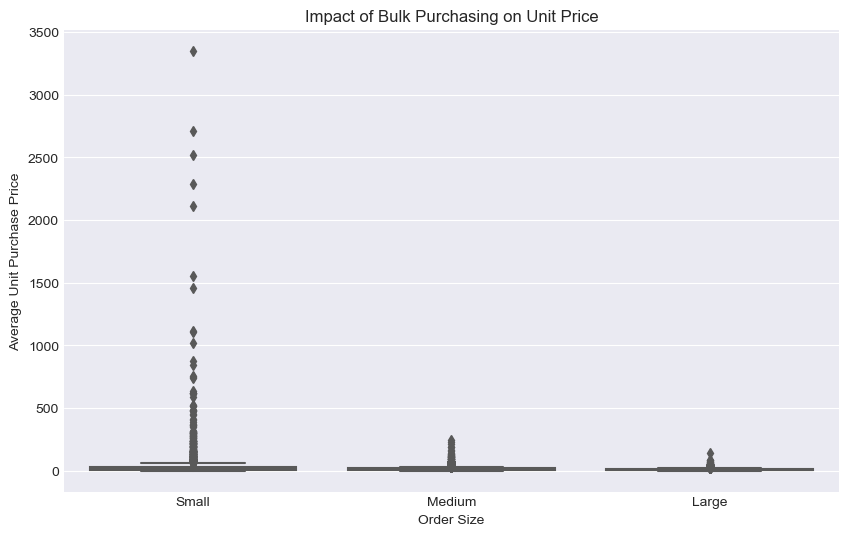

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

- Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
- The price difference between Small and Large orders is substantial (~72% reduction in unit cost)
- This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

### Which vendors have low inventory turnover, indicating excess stock and slow-moving products?

In [59]:
 # Identify Low Inventory Turnover Vendors
low_turnover_vendors = df[df["stock_turnover"] < 1].groupby("vendor_name")["stock_turnover"].mean().reset_index()

# Sort by Lowest Turnover
low_turnover_vendors = low_turnover_vendors.sort_values(by="stock_turnover", ascending=True)
low_turnover_vendors.head(10)

,vendor_name,stock_turnover
0,ALISA CARR BEVERAGES,0.620000
36,HIGHLAND WINE MERCHANTS LLC,0.710000
60,PARK STREET IMPORTS LLC,0.750000
19,Circa Wines,0.755385
41,KLIN SPIRITS LLC,0.760000
26,Dunn Wine Brokers,0.767500
15,CENTEUR IMPORTS LLC,0.772500
78,SMOKY QUARTZ DISTILLERY LLC,0.780000
90,TAMWORTH DISTILLING,0.800000
91,THE IMPORTED GRAPE LLC,0.808182


### The vendors listed above have low inventory turnover, which indicates slow-moving stock. These products are tying up warehouse space and increasing holding costs. The company should review these vendors for better pricing, promotions, or reduced ordering to improve inventory efficiency.

### How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [60]:
# Calculate Unsold Inventory Value
df["UnsoldInventoryValue"] = (df["total_purchase_quantity"] - df["total_sales_quantity"]) * df["purchase_price"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))

# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("vendor_name")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

Total Unsold Capital: 2.71M


,vendor_name,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


### What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors.

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low Vendors 95% CI: (40.50, 42.64), Mean: 41.57


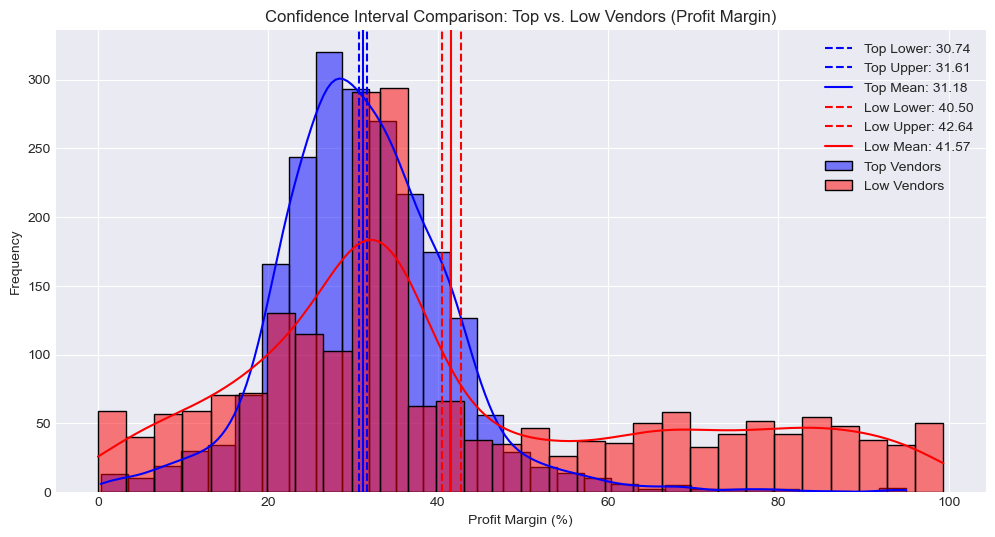

In [61]:
# Define top and low vendors based on Total Sales Dollars (Top 25% & Bottom 25%)
top_threshold = df["total_sales_dollars"].quantile(0.75)
low_threshold = df["total_sales_dollars"].quantile(0.25)

top_vendors = df[df["total_sales_dollars"] >= top_threshold]["profit_margin"].dropna()
low_vendors = df[df["total_sales_dollars"] <= low_threshold]["profit_margin"].dropna()

# Function to compute confidence interval
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

# Compute confidence intervals
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

- The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
- This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
- For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
- For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.

### Is there a significant difference in profit margins between top-performing and low-performing vendors?

Hypothesis:

H₀ (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.

H₁ (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [62]:
top_threshold = df["total_sales_dollars"].quantile(0.75)
low_threshold = df["total_sales_dollars"].quantile(0.25)

top_vendors = df[df["total_sales_dollars"] >= top_threshold]["profit_margin"].dropna()
low_vendors = df[df["total_sales_dollars"] <= low_threshold]["profit_margin"].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")


T-Statistic: -17.6693, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.


- A p-value this small suggests that the difference is not just statistically significant but also practically meaningful.

- The two vendor groups operate very differently in terms of profitability.